In [1]:
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
%reload_ext autoreload
%autoreload 2
import json
import logging
import numpy as np
import pandas as pd
import os
import itertools
from pyeed import Pyeed
import matplotlib.pyplot as plt
from pyeed.analysis.embedding_analysis import EmbeddingTool
from scipy.spatial.distance import pdist, squareform


# SetUp

In [3]:
import os

load_dotenv()  # Load variables from .env
password = os.getenv("NEO4J_NIKLAS_PLAYGROUND")
if password is None:
    raise ValueError("KEY is not set in the .env file.")

In [4]:
uri = "bolt://127.0.0.1:7687"
user = "neo4j"

eedb = Pyeed(uri, user=user, password=password)
# eedb.db.wipe_database(date='2025-01-20')

Pyeed Graph Object Mapping constraints not defined. Use _install_labels() to set up model constraints.
📡 Connected to database.


In [5]:
et = EmbeddingTool()

In [6]:
# read in the pandas dataframe
df = pd.read_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';')
print(df.head())

# df.to_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';', index=False)


  protein_name phenotype    protein_id protein_id_database
0        TEM-1        2b      AAP20891          AAP20891.1
1        TEM-2        2b      CAJ85677          CAJ85677.1
2        TEM-3       2be      SAQ02853          SAQ02853.1
3        TEM-4       2be      CDR98216          CDR98216.1
4        TEM-5       2be  WP_109963600      WP_109963600.1


In [7]:
ids = df['protein_id_database'].dropna().tolist()
labels = df['phenotype'].tolist()

# pd.nan should be None
labels = [None if pd.isna(x) else x for x in labels]

dict_id_label = {}
for i in range(len(ids)):
    dict_id_label[ids[i]] = labels[i]

print(len(ids))
print(len(labels))


209
265


In [8]:
# eedb.fetch_from_primary_db(ids=ids, db="ncbi_protein")

eedb.calculate_sequence_embeddings(model_name="esmc_300m")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

/home/nab/anaconda3/envs/pyeed_niklas/lib/python3.12/site-packages/esm/pretrained.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
2025-01-20 15

# Data SetUp

In [9]:
print(len(ids))

209


In [10]:
# next up is the comaprision of embeddings vs identity
# we want a graph x is cosine similarity and y is identity
# we have all of the data in the database so we can just query it

# first we want the PAIRWISE_ALINED realtionship between the proteins from ids
# second we want thhe embeddduing of the proteins from ids
# we can then calculate the cosine similarity between the embeddings and the identity
query_pairwise = """
MATCH (p1:Protein)-[r:PAIRWISE_ALIGNED]-(p2:Protein)
WHERE p1.accession_id IN $ids AND p2.accession_id IN $ids
RETURN p1.accession_id AS protein1, p2.accession_id AS protein2, r.similarity AS identity, r.target_aligned AS target_aligned, r.query_aligned AS query_aligned, r.mismatches AS mismatches
"""
results_pairwise = eedb.db.execute_read(query_pairwise, {"ids": ids})
print(results_pairwise[:10])

# create a distance matrix based on the pairwise alignment
# the metric used will be identity
# results_pairwise is a list of dictionaries with keys protein1, protein2, identity
# the distance matrix is a numpy array, and there is a list of the protein ids which are the same as the order of the distance matrix
distance_matrix_pairwise = np.zeros((len(ids), len(ids)))
# protein_ids_pairwise is a list of the protein ids which are the same as the order of the distance matrix
# is should have a length of ids, the x and y axis of the distance matrix are the same
protein_ids_pairwise = []

for i in ids:
    for j in ids:
        if i == j:
            distance_matrix_pairwise[ids.index(i), ids.index(j)] = 1
        else:
            # this is the new identity, we look at the target and query seq and find remove all positions with a '-'
            # then we count the number of mismatches and divide by the length of the sequence
            # the identity is 1 - the number of mismatches / the length of the sequence

            # get the data from the results_pairwise
            target_aligned = next(
                (record["target_aligned"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), ''
            )
            query_aligned = next(
                (record["query_aligned"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), ''
            )
            mismatches = next(
                (record["mismatches"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), 0
            )

            """
            # remove the '-' from the target and query aligned
            remove_indices = []
            for k in range(len(target_aligned)):
                if target_aligned[k] == '-':
                    remove_indices.append(k)
                elif query_aligned[k] == '-':
                    remove_indices.append(k)
                
            # remove the indices from the target and query aligned
            target_aligned = ''.join([target_aligned[k] for k in range(len(target_aligned)) if k not in remove_indices])
            query_aligned = ''.join([query_aligned[k] for k in range(len(query_aligned)) if k not in remove_indices])

            # calculate the identity
            identity = 1 - mismatches / len(target_aligned)
            """

            identity = next((record["identity"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), 0)

            distance_matrix_pairwise[ids.index(i), ids.index(j)] = identity
            
    protein_ids_pairwise.append(i)

    


print(len(protein_ids_pairwise))
print(distance_matrix_pairwise.shape)


[]
209
(209, 209)


In [11]:
# np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_default_methode.npy', distance_matrix_pairwise)
# np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_default_methode.npy', protein_ids_pairwise)


In [12]:
query_embedding = """
MATCH (p:Protein)
WHERE p.accession_id IN $ids
RETURN p.accession_id AS protein, p.embedding AS embedding
"""
results_embedding = eedb.db.execute_read(query_embedding, {"ids": ids})

# create a distance matrix based on the embeddings
# the metric used will be cosine similarity
# result is a numpy array and there is a list of the protein ids which are the same as the order of the distance matrix
distance_matrix_embedding = np.zeros((len(ids), len(ids)))
protein_ids_embedding = []

# use pdist to calculate the cosine similarity
# use squareform to get the distance matrix
embeddings = [record["embedding"] for record in results_embedding]
distance_matrix_embeddings_cosine = squareform(pdist(embeddings, metric="cosine"))
distance_matrix_embeddings_euclidean = squareform(pdist(embeddings, metric="euclidean"))
protein_ids_embedding = [record["protein"] for record in results_embedding]

# Data Loading

In [24]:
# we now load the previously saved distance matrix and protein ids
# distance_matrix_embeddings_cosine = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_cosine.npy")
# distance_matrix_embeddings_euclidean = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_euclidean.npy")
# protein_ids_embedding = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_embedding.npy")

distance_matrix_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_default_methode.npy")
protein_ids_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_default_methode.npy")

# distance_matrix_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_mutations.npy")
# protein_ids_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_mutations.npy")

In [25]:
# matrix sizes should be the same
print(distance_matrix_pairwise.shape)
print(distance_matrix_embeddings_cosine.shape)
print(distance_matrix_embeddings_euclidean.shape)

print(len(protein_ids_pairwise))
print(len(protein_ids_embedding)//2)
print((len(protein_ids_embedding)//2)**2)

(209, 209)
(209, 209)
(209, 209)
209
104
10816


In [15]:
print(protein_ids_pairwise[:5])
print(protein_ids_embedding[:5])

['AAP20891.1', 'CAJ85677.1', 'SAQ02853.1', 'CDR98216.1', 'WP_109963600.1']
['AAP20891.1', 'CAJ85677.1', 'SAQ02853.1', 'CDR98216.1', 'WP_109963600.1']


# Plots

In [16]:
embedding_tool = EmbeddingTool()

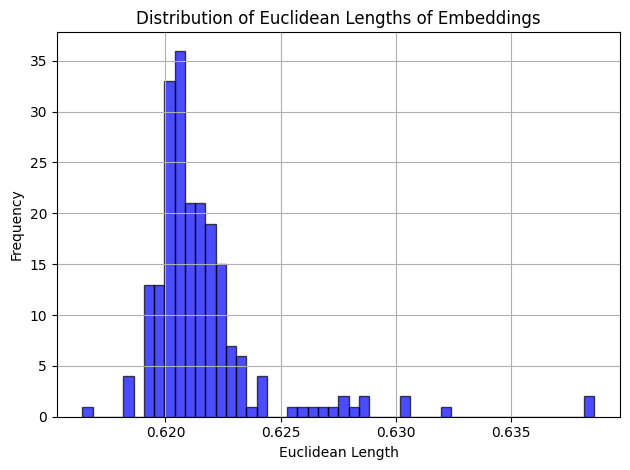

In [17]:
# i want all of the embeddings from the database for all ids
embeddings_all = []

for i in range(len(ids)):
    embeddings_all.append(embedding_tool.get_embedding(ids[i], db=eedb.db))

embeddings_all = np.array(embeddings_all)

# get the histogram plot of the euclidean length of the embeddings
plt.hist(np.linalg.norm(embeddings_all, axis=1), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Euclidean Lengths of Embeddings")
plt.xlabel("Euclidean Length")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()


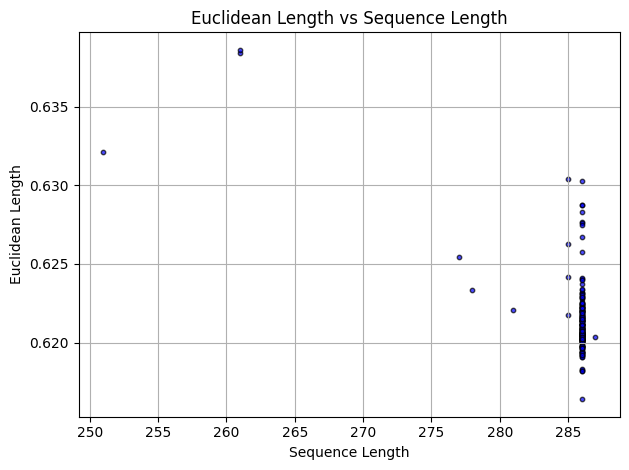

In [18]:
# now i want a 2d plot of the euclidean length of the embeddings vs the sequence length
for i in range(len(ids)):
    # get the sequence length from neo4j, there is a attribute in the protein node called seq_length
    query_seq_length = f"""
    MATCH (p:Protein)
    WHERE p.accession_id = $id
    RETURN p.seq_length AS seq_length
    """
    seq_length = eedb.db.execute_read(query_seq_length, {"id": ids[i]})[0]['seq_length']

    euclidean_length = np.linalg.norm(embeddings_all[i])
    plt.scatter(seq_length, euclidean_length, c='blue', alpha=0.7, s=10, edgecolor="k")
plt.title("Euclidean Length vs Sequence Length")
plt.xlabel("Sequence Length")
plt.ylabel("Euclidean Length")
plt.grid()
plt.tight_layout()
plt.show()


/home/nab/anaconda3/envs/pyeed_niklas/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Number of proteins in visualization: 209
{'2b', '2br', 'None', '2be', '2ber'}
{'2b': 'blue', '2br': 'orange', 'None': 'black', '2be': 'red', '2ber': 'purple'}


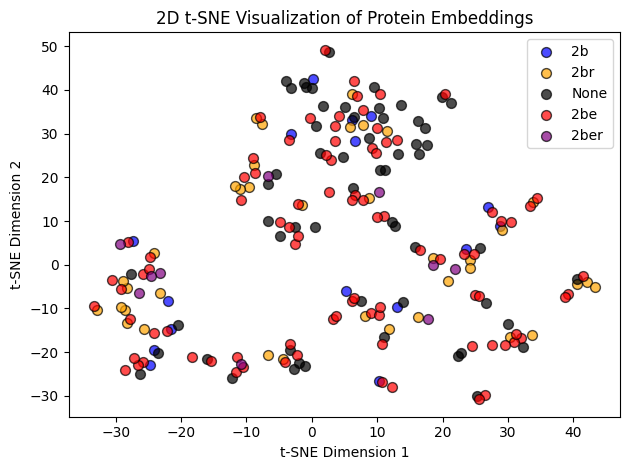

In [26]:
# get all of the data from embedding
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=8, n_iter=3000)

print(f"Number of proteins in visualization: {len(protein_ids)}")

# make the None objects to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# create a scatter plot for each unique label
unique_labels = set(labels)
unique_color_labels = {}
print(unique_labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )
    
    # store the color for the label
    unique_color_labels[label] = colors[indices[0]]

print(unique_color_labels)

plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

 Length of protein_ids_mutations: 209
 Length of protein_ids_pairwise: 209


/tmp/ipykernel_2046521/2320695900.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


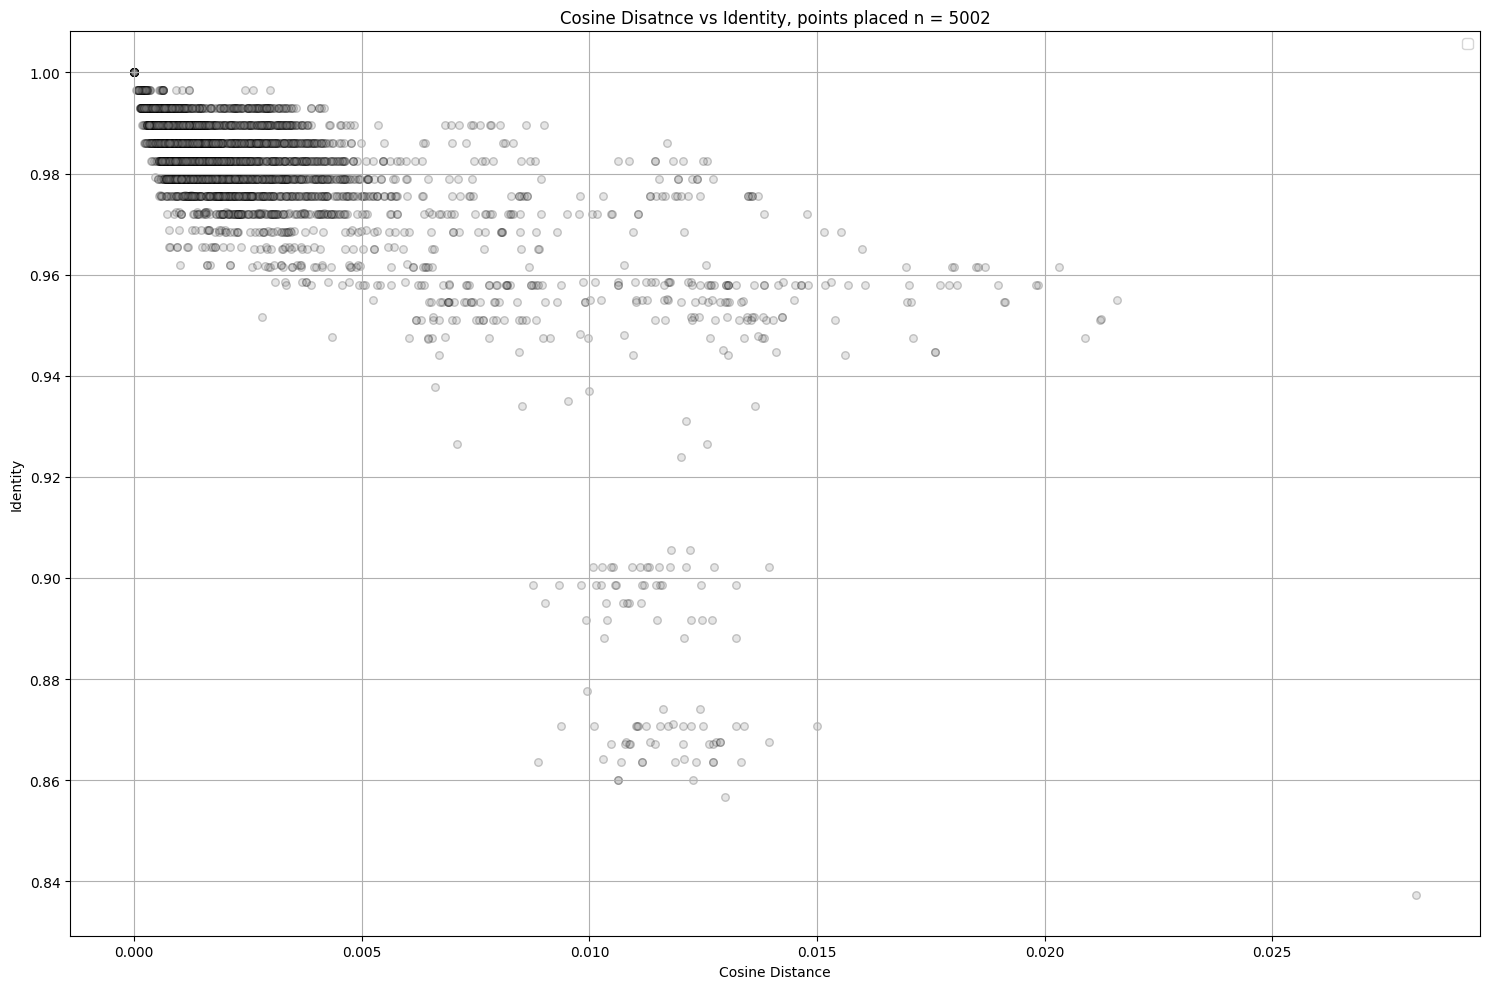

In [27]:
fig = plt.figure(figsize=(15, 10))

number_of_points_goal = 5000
total_number_of_points = distance_matrix_pairwise.shape[0] * distance_matrix_pairwise.shape[1]
random_chance_probability = number_of_points_goal / total_number_of_points
point_counter = 0

data_matrix = []

protein_ids_embedding = np.array(protein_ids_embedding)
protein_ids_pairwise = np.array(protein_ids_pairwise)

print(f" Length of protein_ids_mutations: {len(protein_ids_embedding)}")
print(f" Length of protein_ids_pairwise: {len(protein_ids_pairwise)}")

for i in range(len(protein_ids_embedding)):
    for j in range(len(protein_ids_pairwise)):

        if np.random.rand() < random_chance_probability:
            # plt.scatter(distance_matrix_mutations[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            # does not work since the ids are not the same

            mutations_id = protein_ids_embedding[i]
            pairwise_id = protein_ids_pairwise[j]

            if mutations_id == pairwise_id:
                plt.scatter(distance_matrix_embeddings_cosine[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
                data_matrix.append([distance_matrix_embeddings_cosine[i, j], distance_matrix_pairwise[i, j], mutations_id, pairwise_id])
            else:
                # we need to find the index of the pairwise_id in the protein_ids_mutations array from numpy
                # the i is the index in the protein_ids_mutations array this means we are looking of the index to j in the protein_ids_mutations array
                index_mutations_id = np.where(protein_ids_embedding == pairwise_id)[0][0]
                # now the index of the mutations_id is the index of the pairwise_id in the protein_ids_pairwise array
                index_pairwise_id = np.where(protein_ids_pairwise == mutations_id)[0][0]

                plt.scatter(distance_matrix_embeddings_cosine[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], c='gray', alpha=0.2, s=30, edgecolor="k")
                data_matrix.append([distance_matrix_embeddings_cosine[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], mutations_id, pairwise_id])
            
            point_counter += 1
        
        if point_counter > number_of_points_goal:
            break
        
    
plt.title("Cosine Disatnce vs Identity, points placed n = " + str(point_counter))
plt.xlabel("Cosine Distance")
plt.ylabel("Identity")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


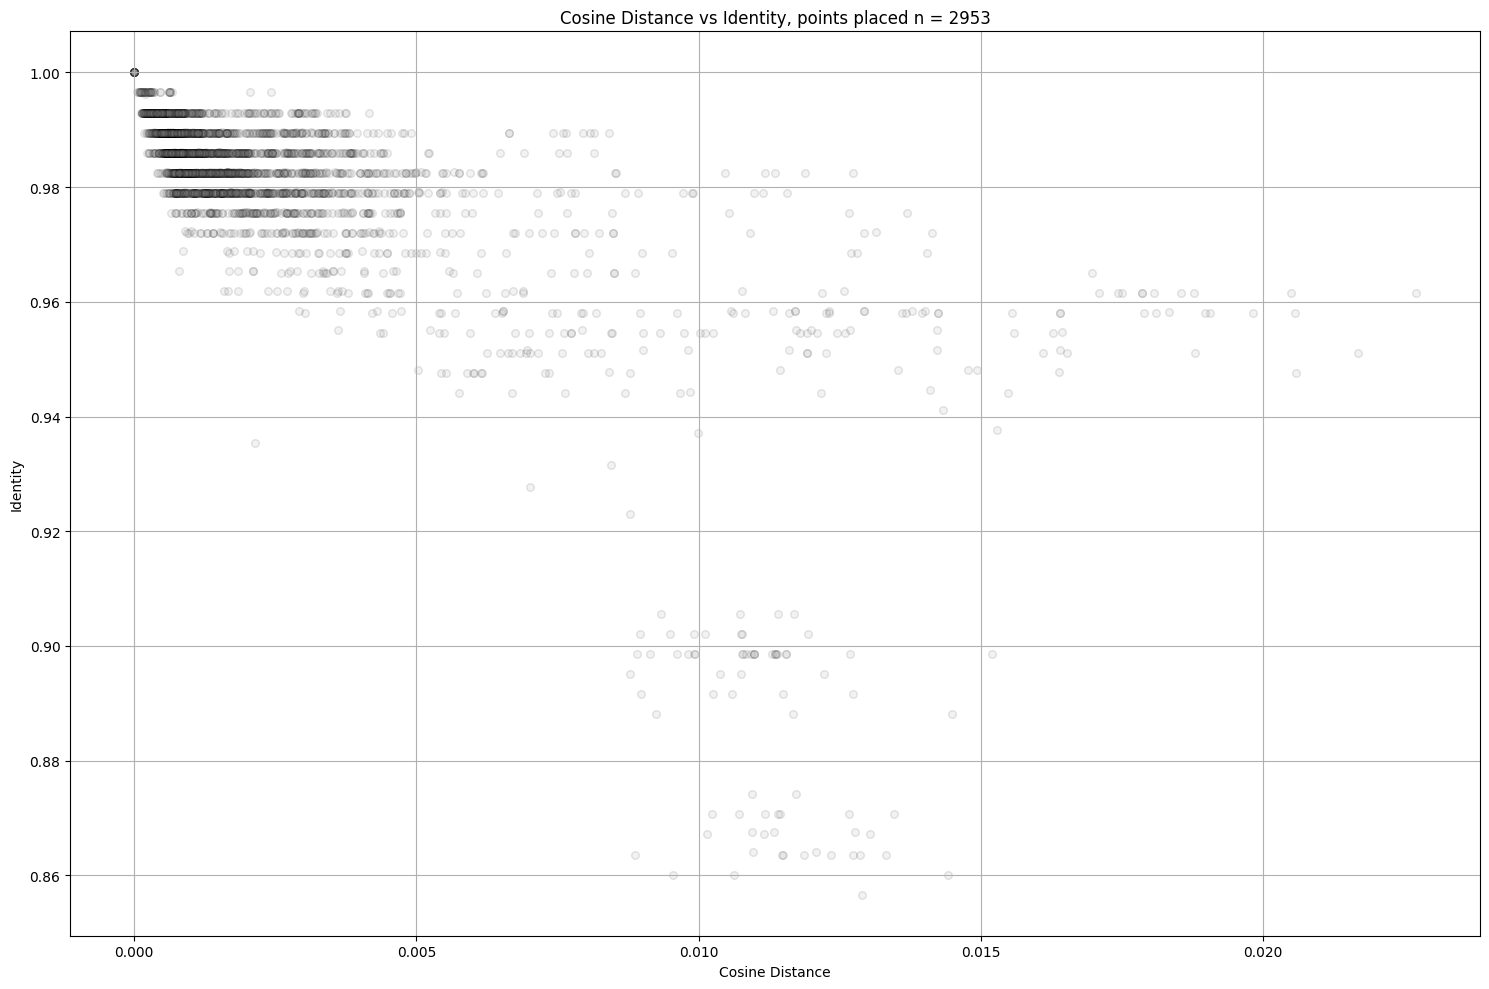

In [28]:
fig = et.plot_matrix_comparison(distance_matrix_embeddings_cosine, distance_matrix_pairwise, protein_ids_embedding, protein_ids_pairwise, "Cosine Distance", "Identity", 3000)
fig.show()

In [22]:
data_matrix_ARRAY = np.array(data_matrix)
# the first column is the cosine similarity, the second is the identity, the third is the mutations_id and the fourth is the pairwise_id
# there fore the first two should be of type float and the last two of type string
data_matrix_ARRAY[:, 0] = data_matrix_ARRAY[:, 0].astype(float)
data_matrix_ARRAY[:, 1] = data_matrix_ARRAY[:, 1].astype(float)
data_matrix_ARRAY[:, 2] = data_matrix_ARRAY[:, 2].astype(str)
data_matrix_ARRAY[:, 3] = data_matrix_ARRAY[:, 3].astype(str)

print(data_matrix_ARRAY.shape)

# find the point with identity 1 and a cosine of bigger than 0.003
# then outpur the ids
for i in range(len(data_matrix_ARRAY)):
    if float(data_matrix_ARRAY[i, 1]) > 0.99999 and float(data_matrix_ARRAY[i, 0]) > 0.003:
        print('......................')
        print(data_matrix_ARRAY[i, 2], data_matrix_ARRAY[i, 3])
        print(f"Identity: {data_matrix_ARRAY[i, 1]}, Cosine Similarity: {data_matrix_ARRAY[i, 0]}")
        print(f"Label of {data_matrix_ARRAY[i, 2]}: {dict_id_label_new_ids_none[data_matrix_ARRAY[i, 2]]}")
        print(f"Label of {data_matrix_ARRAY[i, 3]}: {dict_id_label_new_ids_none[data_matrix_ARRAY[i, 3]]}")
        print('......................')
        print('\n')

(5001, 4)


# Stuff

In [23]:
# same plot as before but with euclidean distance

fig = plt.figure(figsize=(15, 10))

number_of_points_goal = 5000
total_number_of_points = distance_matrix_embeddings_euclidean.shape[0] * distance_matrix_embeddings_euclidean.shape[1]
random_chance_probability = number_of_points_goal / total_number_of_points
point_counter = 0

for i in range(len(protein_ids_embedding)):
    for j in range(len(protein_ids_pairwise)):

        if np.random.rand() < random_chance_probability:
            # plt.scatter(distance_matrix_embedding_euclidean[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            # does not work since the ids are not the same

            mutations_id = protein_ids_embedding[i]
            pairwise_id = protein_ids_pairwise[j]

            if mutations_id == pairwise_id:
                plt.scatter(distance_matrix_embeddings_euclidean[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            else:
                # we need to find the index of the pairwise_id in the protein_ids_mutations array from numpy
                # the i is the index in the protein_ids_mutations array this means we are looking of the index to j in the protein_ids_mutations array
                index_mutations_id = np.where(protein_ids_embedding == pairwise_id)[0][0]
                # now the index of the mutations_id is the index of the pairwise_id in the protein_ids_pairwise array
                index_pairwise_id = np.where(protein_ids_pairwise == mutations_id)[0][0]

                plt.scatter(distance_matrix_embeddings_euclidean[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            
            point_counter += 1
        
plt.title("Euclidean Distance vs Identity, points placed n = " + str(point_counter))
plt.xlabel("Euclidean Distance")
plt.ylabel("Identity")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'distance_matrix_embedding_euclidean' is not defined

<Figure size 1500x1000 with 0 Axes>

21736


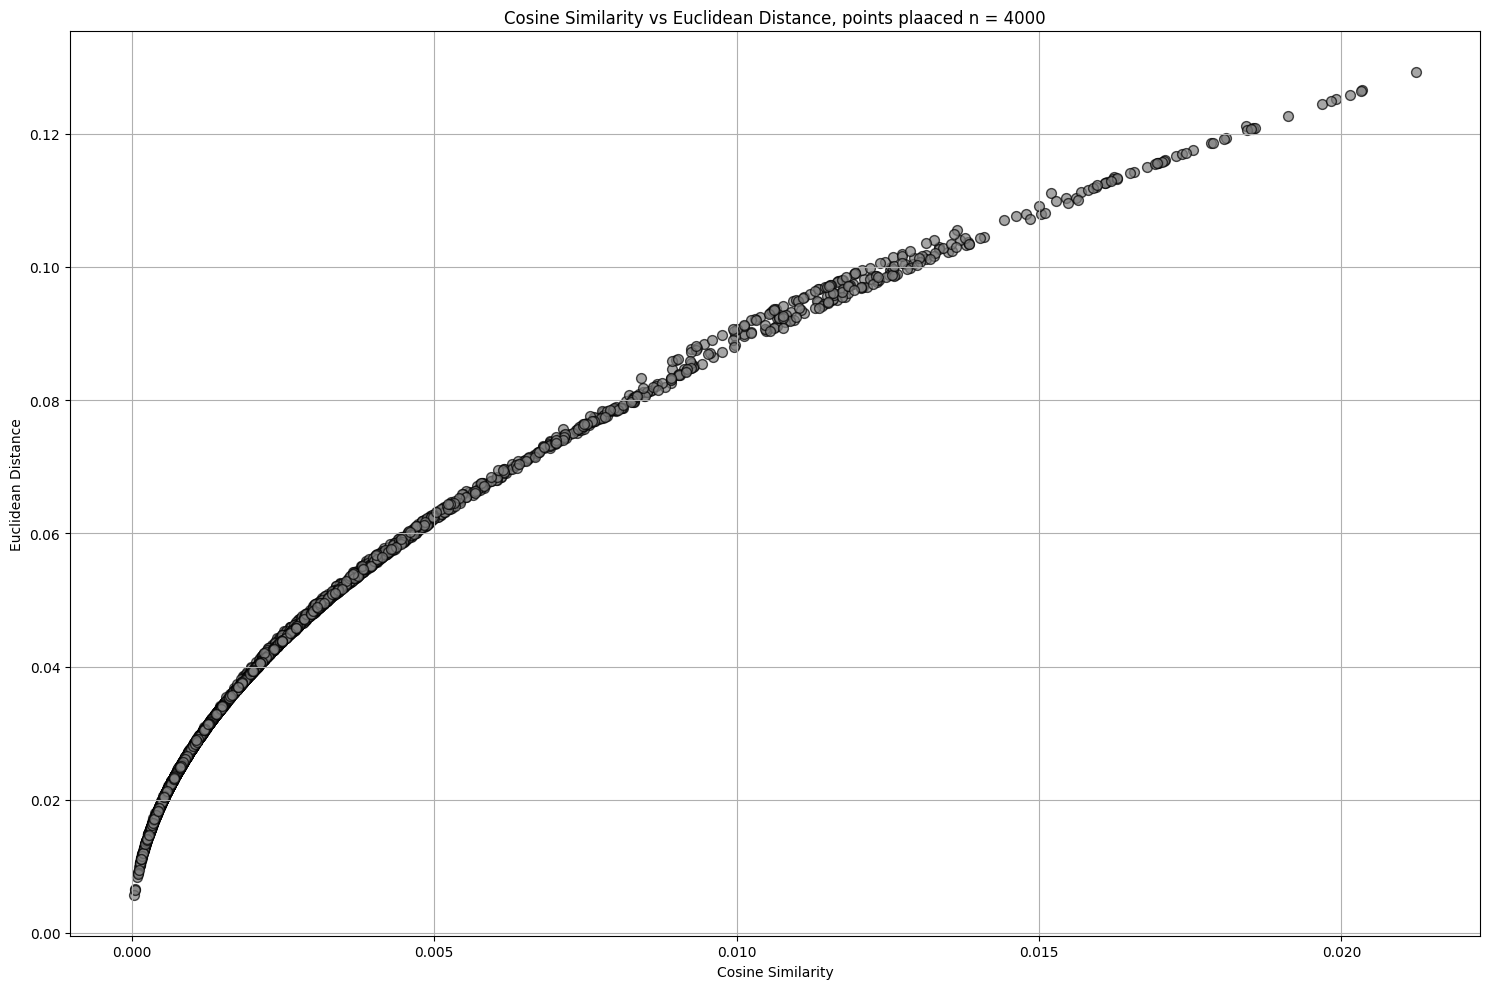

In [31]:
# create the scatter plot with cosine vs euclidian

fig = plt.figure(figsize=(15, 10))

# tracking
count_points = 0
already_plotted_labels = set()

# get all combinations of indexes but skip the second half of the matrix
combinations_of_indexes = list(itertools.combinations(range(len(protein_ids)), 2))
print(len(combinations_of_indexes))
total_number = len(combinations_of_indexes)
random_choices = np.random.choice(total_number, 4000, replace=False)


for index in random_choices:

    i = combinations_of_indexes[index][0]
    j = combinations_of_indexes[index][1]
    if i == j:
        continue

    

    plt.scatter(
        distance_matrix_embeddings_cosine[i, j],
        distance_matrix_embeddings_euclidean[i, j],
        label=label,
        alpha=0.7,
        s=50,
        c='gray',
        edgecolor="k",
    )

    count_points += 1

    if count_points > 20000:
        break

plt.title("Cosine Similarity vs Euclidean Distance, points plaaced n = " + str(count_points))
plt.xlabel("Cosine Similarity")
plt.ylabel("Euclidean Distance")
plt.grid()
plt.tight_layout()
plt.show()




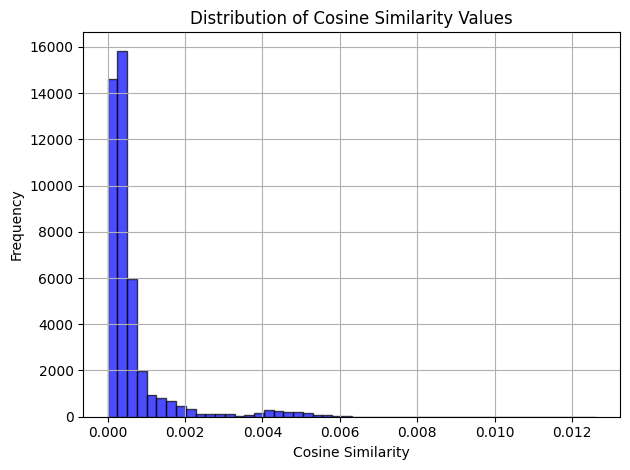

In [29]:
# plot the distribution of the cosine similarity values on a histogram
# use the cosine similarity values from the distance matrix

plt.hist(distance_matrix_embedding_cosine.flatten(), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Cosine Similarity Values")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()

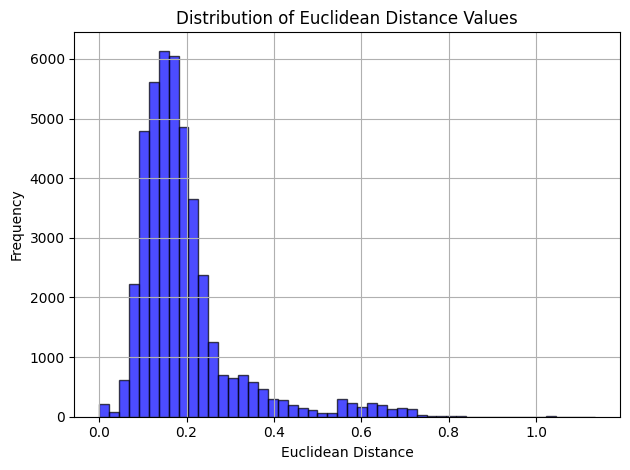

In [30]:
# plot the distribution of the euclidean distance values on a histogram
# use the euclidean distance values from the distance matrix

plt.hist(distance_matrix_embedding_euclidean.flatten(), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Euclidean Distance Values")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()


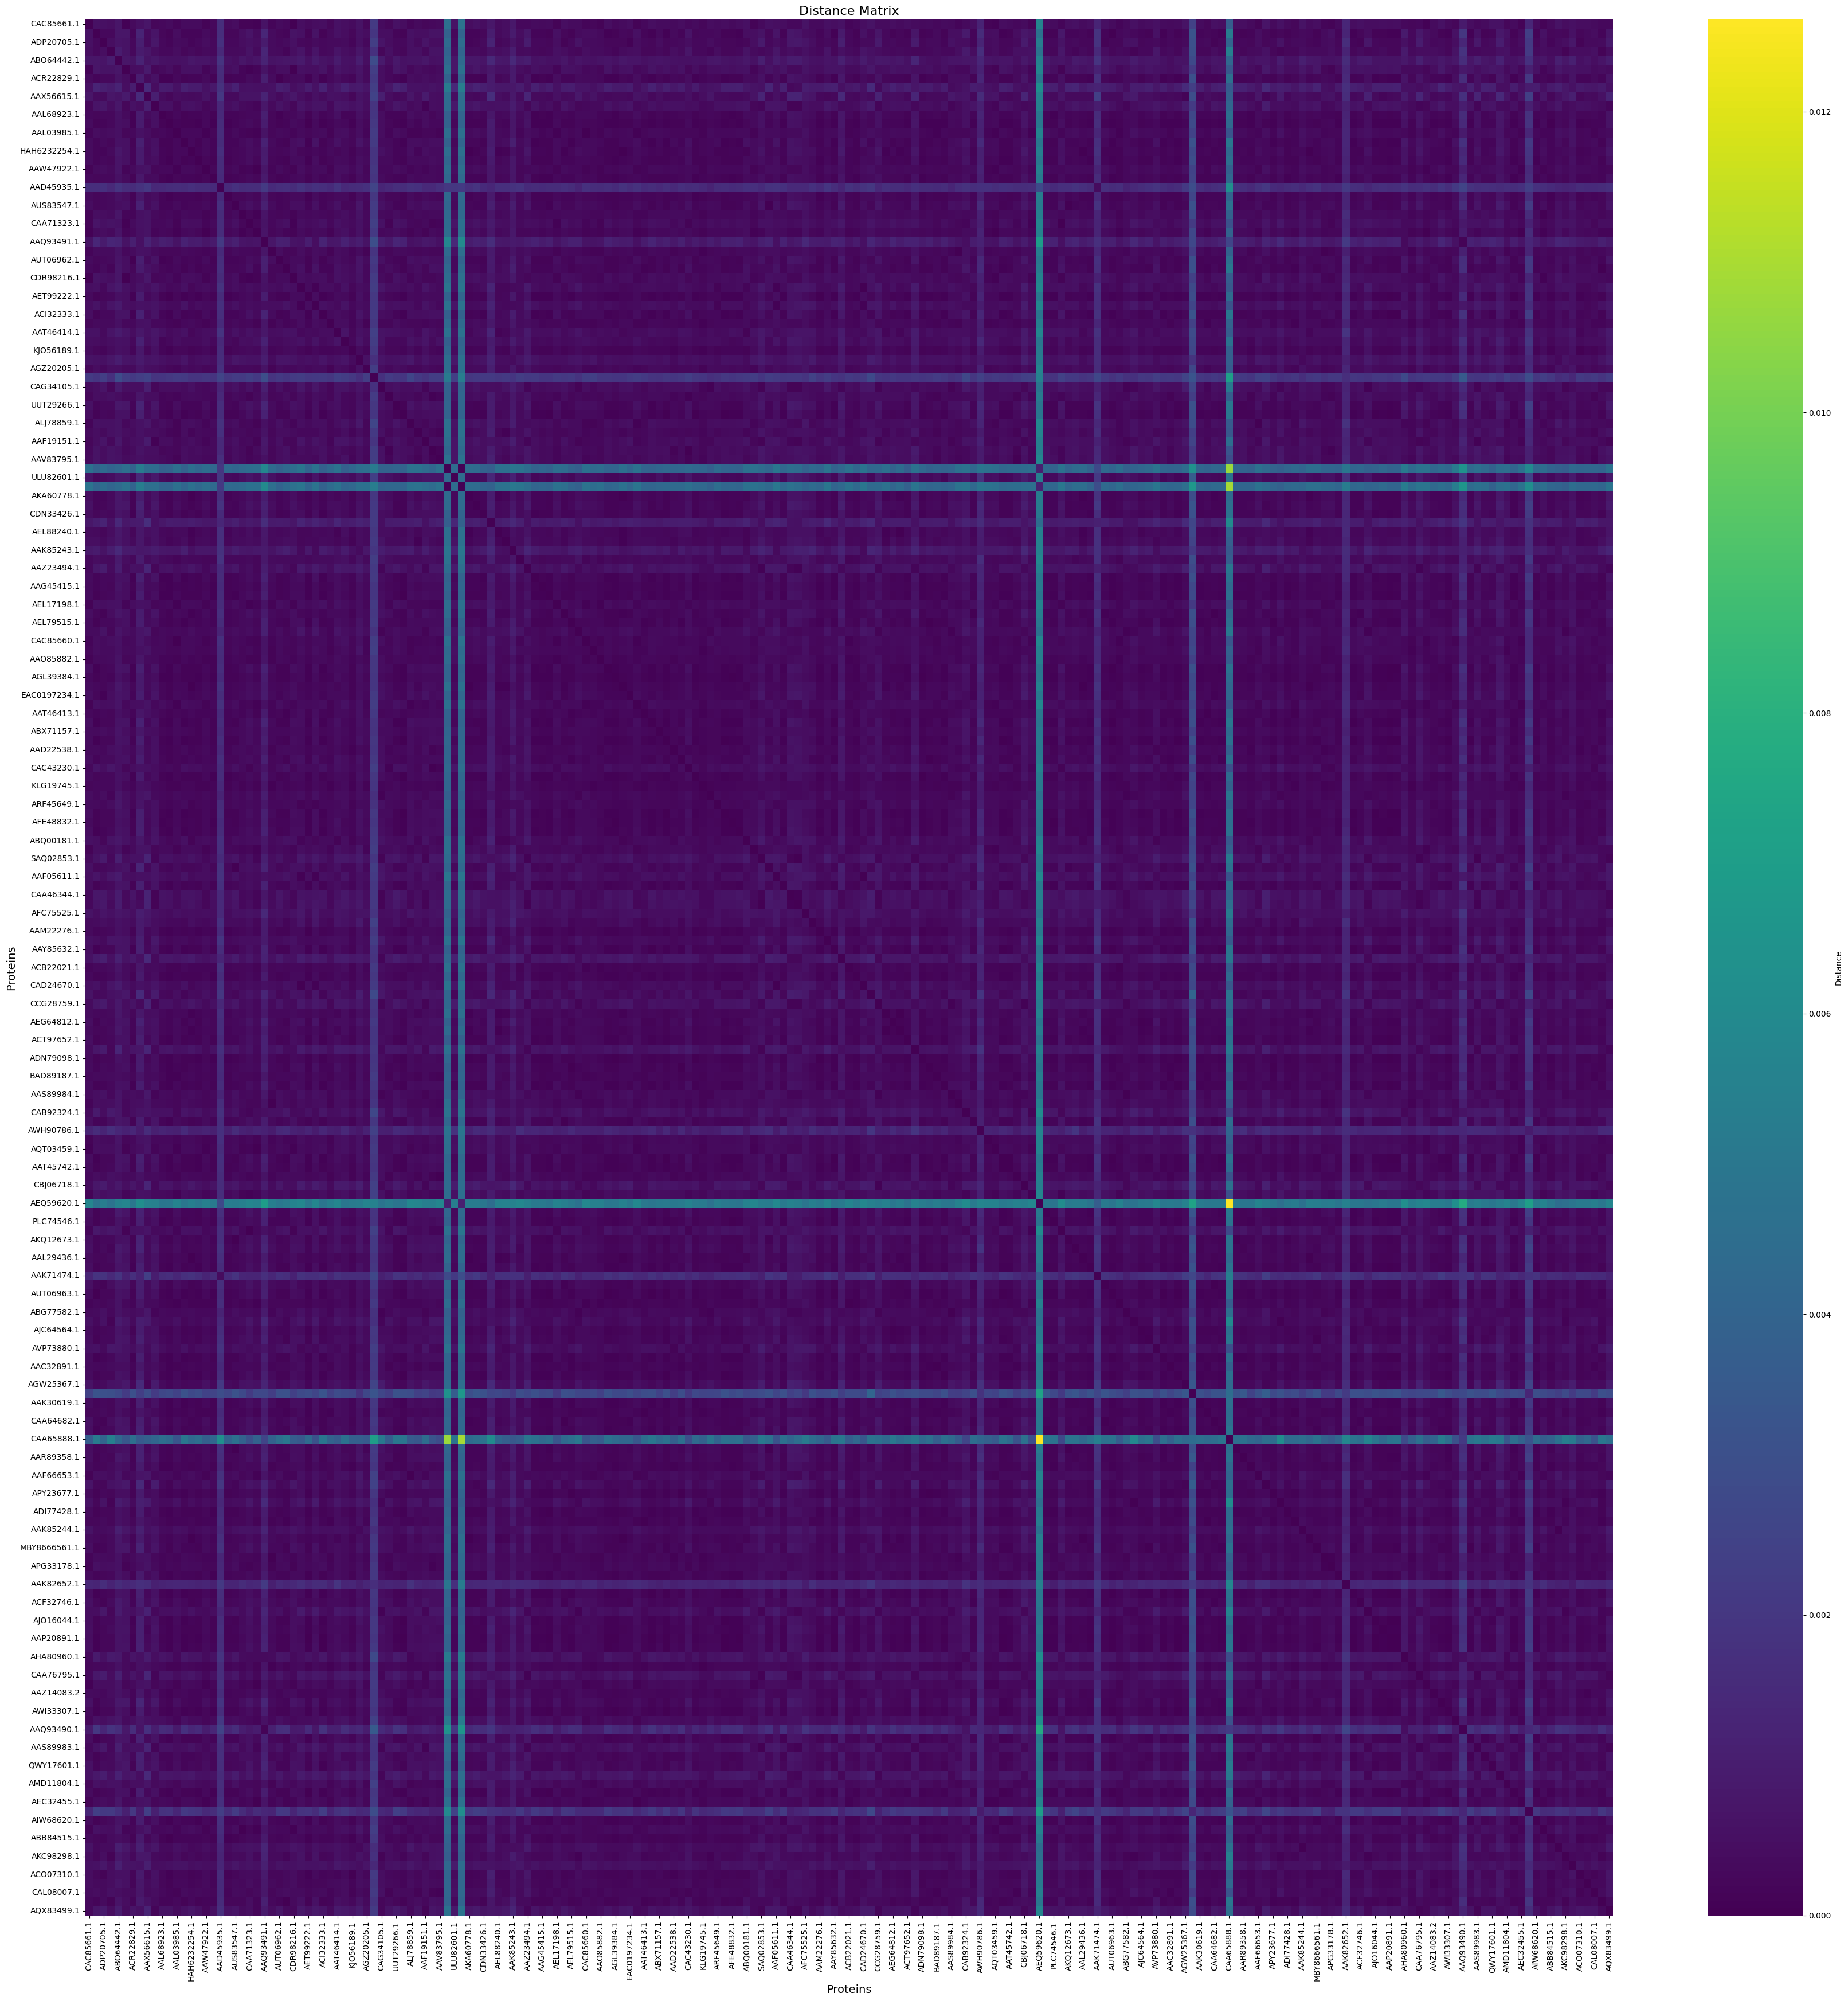